In [470]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import re
import seaborn as sns

In [471]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [472]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Пропуски в стобцах с географическими координатами lat — географическая широта отеля и lng — географическая долгота отеля.

In [473]:
mask1 = hotels['lat'].isna() == True
mask2 = hotels['lng'].isna() == True

print(sum(hotels[mask1].index != hotels[mask2].index))

0


Пропущены значения lat и lng в одних строках.

In [474]:
# Находим пропущенные значения используя библиотеку geopy
list_index = hotels[mask1|mask2].index # Список индексов пропущеных значений

from geopy.geocoders import ArcGIS
geolocator_arcgis = ArcGIS()

for i in list_index:
    geo = geolocator_arcgis.geocode(hotels['hotel_address'][i])
    hotels['lng'][i] = geo.longitude
    hotels['lat'][i] = geo.latitude

C:\Users\dyaki\AppData\Local\Temp\ipykernel_28588\845811082.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels['lng'][i] = geo.longitude
C:\Users\dyaki\AppData\Local\Temp\ipykernel_28588\845811082.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels['lat'][i] = geo.latitude
C:\Users\dyaki\AppData\Local\Temp\ipykernel_28588\845811082.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels['lng'][i] = geo.longitude
C:\U

In [475]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
lng_mm = mm_scaler.fit_transform(hotels[['lng']])

# Заменяем значения на нормализованные
hotels['lng'] = lng_mm

In [476]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'additional_number_of_scoring', 
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = ['average_score', 'lat', 'lng']

In [477]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

In [478]:
# Функция для поиска и создания бинарных признаков
def find_text(df, column, key_column):
    for i in column:
        df[key_column + '_' + i] = df[key_column].apply(lambda x: 1 if x == i else 0)

In [479]:
# Создаем бинарные признаки по первым 10-и наиболее распространненым странам рецензента
find_text(df=hotels, column=list(hotels['reviewer_nationality'].value_counts(normalize=True).head(10).to_dict().keys()),
             key_column='reviewer_nationality')
# Удаляем признак страны рецензента
hotels = hotels.drop(columns=['reviewer_nationality'], axis=1) 

In [480]:
# Подгружаем датафрейм со странами и создаем список с наименованием стран
countries = pd.read_csv('data/country_population.csv', sep=';')
countries_lst=countries['country'].to_list()
print(countries_lst)

# Функция для нахождения страны в тексте
def find_country(text):
    for country in countries_lst:
        if country in text:
            return country
    return 0

['China', 'India', 'US', 'Indonesia', 'Pakistan', 'Brazil', 'Nigeria', 'Bangladesh', 'Russia', 'Mexico', 'Japan', 'Ethiopia', 'Philippines', 'Egypt', 'Vietnam', 'DR Congo', 'Iran', 'Turkey', 'Germany', 'France', 'United Kingdom', 'Thailand', 'South Africa', 'Tanzania', 'Italy', 'Myanmar', 'South Korea', 'Colombia', 'Kenya', 'Spain', 'Argentina', 'Algeria', 'Sudan', 'Uganda', 'Ukraine', 'Iraq', 'Canada', 'Poland', 'Morocco', 'Uzbekistan', 'Saudi Arabia', 'Peru', 'Afghanistan', 'Malaysia', 'Angola', 'Mozambique', 'Ghana', 'Yemen', 'Nepal', 'Venezuela', 'Ivory Coast', 'Madagascar', 'Australia', 'North Korea', 'Cameroon', 'Niger', 'Taiwan', 'Sri Lanka', 'Burkina Faso', 'Mali', 'Chile', 'Romania', 'Kazakhstan[b]', 'Malawi', 'Zambia', 'Syria', 'Ecuador', 'Netherlands', 'Senegal', 'Guatemala', 'Chad', 'Somalia', 'Zimbabwe', 'Cambodia', 'South Sudan', 'Rwanda', 'Guinea', 'Burundi', 'Benin', 'Bolivia', 'Tunisia', 'Haiti', 'Belgium', 'Cuba', 'Jordan', 'Greece', 'Czech Republic', 'Dominican Repub

In [481]:
# Выводим наименование страны в отдельный признак из адреса
hotels['country'] = hotels['hotel_address'].apply(lambda x: find_country(x))

In [482]:
hotels['country'].value_counts()

country
United Kingdom    196774
Spain              45132
France             44781
Netherlands        43006
Austria            29178
Italy              27883
Mexico                49
Name: count, dtype: int64

In [483]:
# Создаем бинарные признаки по странам отелей
find_text(df=hotels, column=list(hotels['country'].value_counts().to_dict().keys()),
             key_column='country')
# Удаляем признак страны отеля
hotels = hotels.drop(columns=['country', 'hotel_address'], axis=1) 

In [484]:
# Удаляем признаки наименования отеля, отрицательный отзыв и положительный отзыв
hotels = hotels.drop(columns=['hotel_name', 'negative_review', 'positive_review'], axis=1) 

In [485]:
# Создаем признак количества дней между датой проверки и датой очистки с типом данных integer
hotels['days_since_review_int'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
# Удаляем признак количества дней между датой проверки и датой очистки с типом данных object
hotels = hotels.drop(columns=['days_since_review'], axis=1) 

In [486]:
# Создаем список уникальных тегов
regex = "' [^,]+ '" # регулярное выражение для нахождения тэгов
tags = []
for i in hotels['tags']:
    k = re.findall(regex, i)
    for j in k:
        tags.append(j[2:(len(j)-2)])
tags = list(set(tags))
print(len(tags))

2368


In [487]:
# Создаем список уникальных значений с количеством дней проведенных рецензентом в отеле
regex = "' [^,]+\d+ nigh[^,]+ '" # регулярное выражение для нахождения тэгов
tags_n = []
for i in hotels['tags']:
    k = re.findall(regex, i)
    for j in k:
        tags_n.append(j[2:(len(j)-2)])
tags_n = list(set(tags_n))
print(len(tags_n))

31


In [488]:
# Удаляем из общего списка тегов теги с количеством дней проведенных рецензентом в отеле
for i in tags_n:
    tags.remove(i)
print(len(tags))

2337


In [489]:
# Находим 10 наиболее часто встречающихся тегов
new_tags=[]
str_tags_lst = []
hotels['tags'].apply(lambda x: str_tags_lst.append(x))
str_tags = ' '.join(str_tags_lst)
for k in range(10):
    z = 0
    for i in tags:
        if str_tags.count(i) > z:
            z = str_tags.count(i)
            tag = i
    print(tag)
    new_tags.append(tag)
    tags.remove(tag)

Leisure trip
Submitted from a mobile device
Couple
Double Room
Twin Room
Solo traveler
Standard
Superior
Double or Twin Room
Business trip


In [490]:
# Функция для нахождения тегов и создание бинарных признаков тегов
def find_tags(df, column, key_column):
    for i in column:
        df[key_column + '_' + i] = df[key_column].apply(lambda x: 1 if i in x else 0)

In [491]:
# Содаем бинарные признаки тегов
find_tags(df=hotels, column=new_tags,
             key_column='tags')

In [492]:
# Ищем количество ночей, на сколько рецензенты останавливаются чаще всего
z = 0
for i in tags_n:
    if str_tags.count(i) > z:
        z = str_tags.count(i)
        tag_n = i
print(tag_n)

Stayed 1 night


In [493]:
# Функция поиска числового значения количества ночей из тегов 
def find_nights_count(text):
    for n in tags_n:
        if n in text:
            return int(re.findall('\d+', n)[0])
    return 1

In [494]:
# Создаем признак количества ночей проведенных рецензетом в отеле
hotels['nights_count'] = hotels['tags'].apply(lambda x: find_nights_count(x))

In [495]:
# Удаляем признак тегов из датафрейма
hotels = hotels.drop(columns=['tags'], axis=1) 

<Axes: >

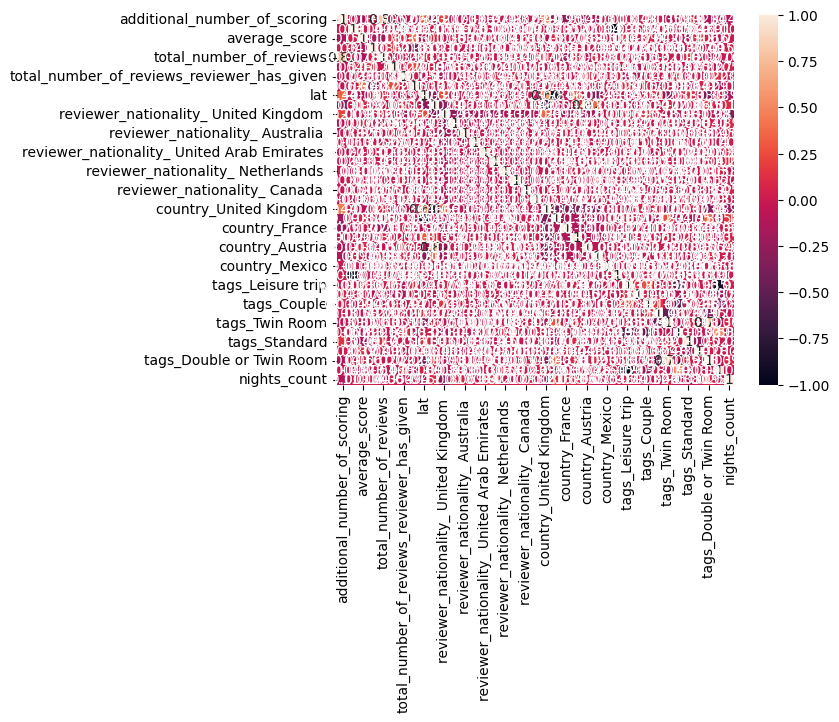

In [496]:
# Строим тепловую карту корреляции признаков
sns.heatmap(hotels.corr(), annot=True)

In [497]:
# Удалям признак действительных оценок
hotels = hotels.drop(columns=['additional_number_of_scoring'], axis=1) 

In [498]:
# Создаем бинарные признаки года
hotels['review_year_2015'] = hotels['review_date'].dt.year.apply(lambda x: 1 if x == 2015 else 0)
hotels['review_year_2016'] = hotels['review_date'].dt.year.apply(lambda x: 1 if x == 2016 else 0)
hotels['review_year_2017'] = hotels['review_date'].dt.year.apply(lambda x: 1 if x == 2017 else 0)

In [499]:
# Создаем бинарные признаки сезона
hotels['review_winter'] = hotels['review_date'].dt.month.apply(lambda x: 1 if x in [1, 2, 12] else 0)
hotels['review_summer'] = hotels['review_date'].dt.month.apply(lambda x: 1 if x in [6, 7, 8] else 0)
hotels['review_spring'] = hotels['review_date'].dt.month.apply(lambda x: 1 if x in [3, 4, 5] else 0)
hotels['review_autumn'] = hotels['review_date'].dt.month.apply(lambda x: 1 if x in [9, 10, 11] else 0)

In [500]:
# Создаем бинарный признак выходного дня
hotels['review_weekend'] = hotels['review_date'].dt.weekday.apply(lambda x: 1 if x in [5, 6] else 0)

In [501]:
# Удаляем признак даты
hotels = hotels.drop(columns=['review_date'], axis=1) 

In [502]:
# Функцию создания бинарных признаков ночей проживания рецензентов в отеле и удаления признака, к котором ищем из датафрейма
def count_nights(df, column, key_column):
    for i in column:
        df[key_column + '_' + str(i)] = df[key_column].apply(lambda x: 1 if i == x else 0)
    df = df.drop(columns = [key_column], axis=1)

In [503]:
# Создаем бинарные признаки ночей проживания (топ 10 по частоте) и удаляем исходный признак
count_nights(df=hotels, column=list(hotels['nights_count'].value_counts().head(10).to_dict().keys()),
             key_column='nights_count')

In [504]:
hotels.describe()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,reviewer_nationality_ United Kingdom,reviewer_nationality_ United States of America,...,nights_count_1,nights_count_2,nights_count_3,nights_count_4,nights_count_5,nights_count_6,nights_count_7,nights_count_8,nights_count_9,nights_count_10
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,...,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.433452,0.194186,0.475780,0.068616,...,0.376210,0.259209,0.186141,0.092419,0.040359,0.019129,0.014346,0.004938,0.002497,0.001714
std,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.460948,0.277765,0.499414,0.252801,...,0.484434,0.438201,0.389221,0.289617,0.196800,0.136977,0.118912,0.070097,0.049912,0.041366
min,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214066,0.013476,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,0.023194,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,0.310192,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [528]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 55 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   average_score                                    386803 non-null  float64
 1   review_total_negative_word_counts                386803 non-null  float64
 2   total_number_of_reviews                          386803 non-null  float64
 3   review_total_positive_word_counts                386803 non-null  float64
 4   total_number_of_reviews_reviewer_has_given       386803 non-null  float64
 5   reviewer_score                                   386803 non-null  float64
 6   lat                                              386803 non-null  float64
 7   lng                                              386803 non-null  float64
 8   reviewer_nationality_ United Kingdom             386803 non-null  int64  
 9   reviewer_nation

10 признаков с типом данных float и 45 признаков с типом данных int.

In [505]:
# Нормализуем признаки с помощью нормализатора RobustScaler
r_scaler = preprocessing.RobustScaler()
# Кодируем исходный датасет
df_r = r_scaler.fit_transform(hotels)
# Преобразуем промежуточный датасет в полноценный датафрейм
df_r = pd.DataFrame(df_r, columns=hotels.columns)
# Заменяем признаки на нормализованные
hotels['average_score'] = df_r['average_score']
hotels['review_total_negative_word_counts'] = df_r['review_total_negative_word_counts']
hotels['total_number_of_reviews'] = df_r['total_number_of_reviews']
hotels['review_total_positive_word_counts'] = df_r['review_total_positive_word_counts']
hotels['total_number_of_reviews_reviewer_has_given'] = df_r['total_number_of_reviews_reviewer_has_given']
hotels['days_since_review_int'] = df_r['days_since_review_int']
hotels['nights_count'] = df_r['nights_count']


In [506]:
hotels.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,reviewer_nationality_ United Kingdom,reviewer_nationality_ United States of America,...,nights_count_1,nights_count_2,nights_count_3,nights_count_4,nights_count_5,nights_count_6,nights_count_7,nights_count_8,nights_count_9,nights_count_10
0,0.000000,-0.285714,-0.057096,-0.411765,0.571429,10.0,51.507894,0.013458,1,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.142857,-0.285714,-0.315253,-0.529412,1.571429,6.3,51.521009,0.014683,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0.714286,-0.142857,-0.704731,-0.647059,1.571429,7.5,48.845377,0.160450,0,0,...,0,0,1,0,0,0,0,0,0,0
3,-1.285714,-0.428571,-0.622757,0.000000,0.714286,10.0,48.888697,0.164551,1,0,...,1,0,0,0,0,0,0,0,0,0
4,0.142857,-0.238095,2.223491,0.529412,1.000000,9.6,52.385601,0.310544,0,0,...,0,0,0,0,0,1,0,0,0,0


In [508]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']

<Axes: >

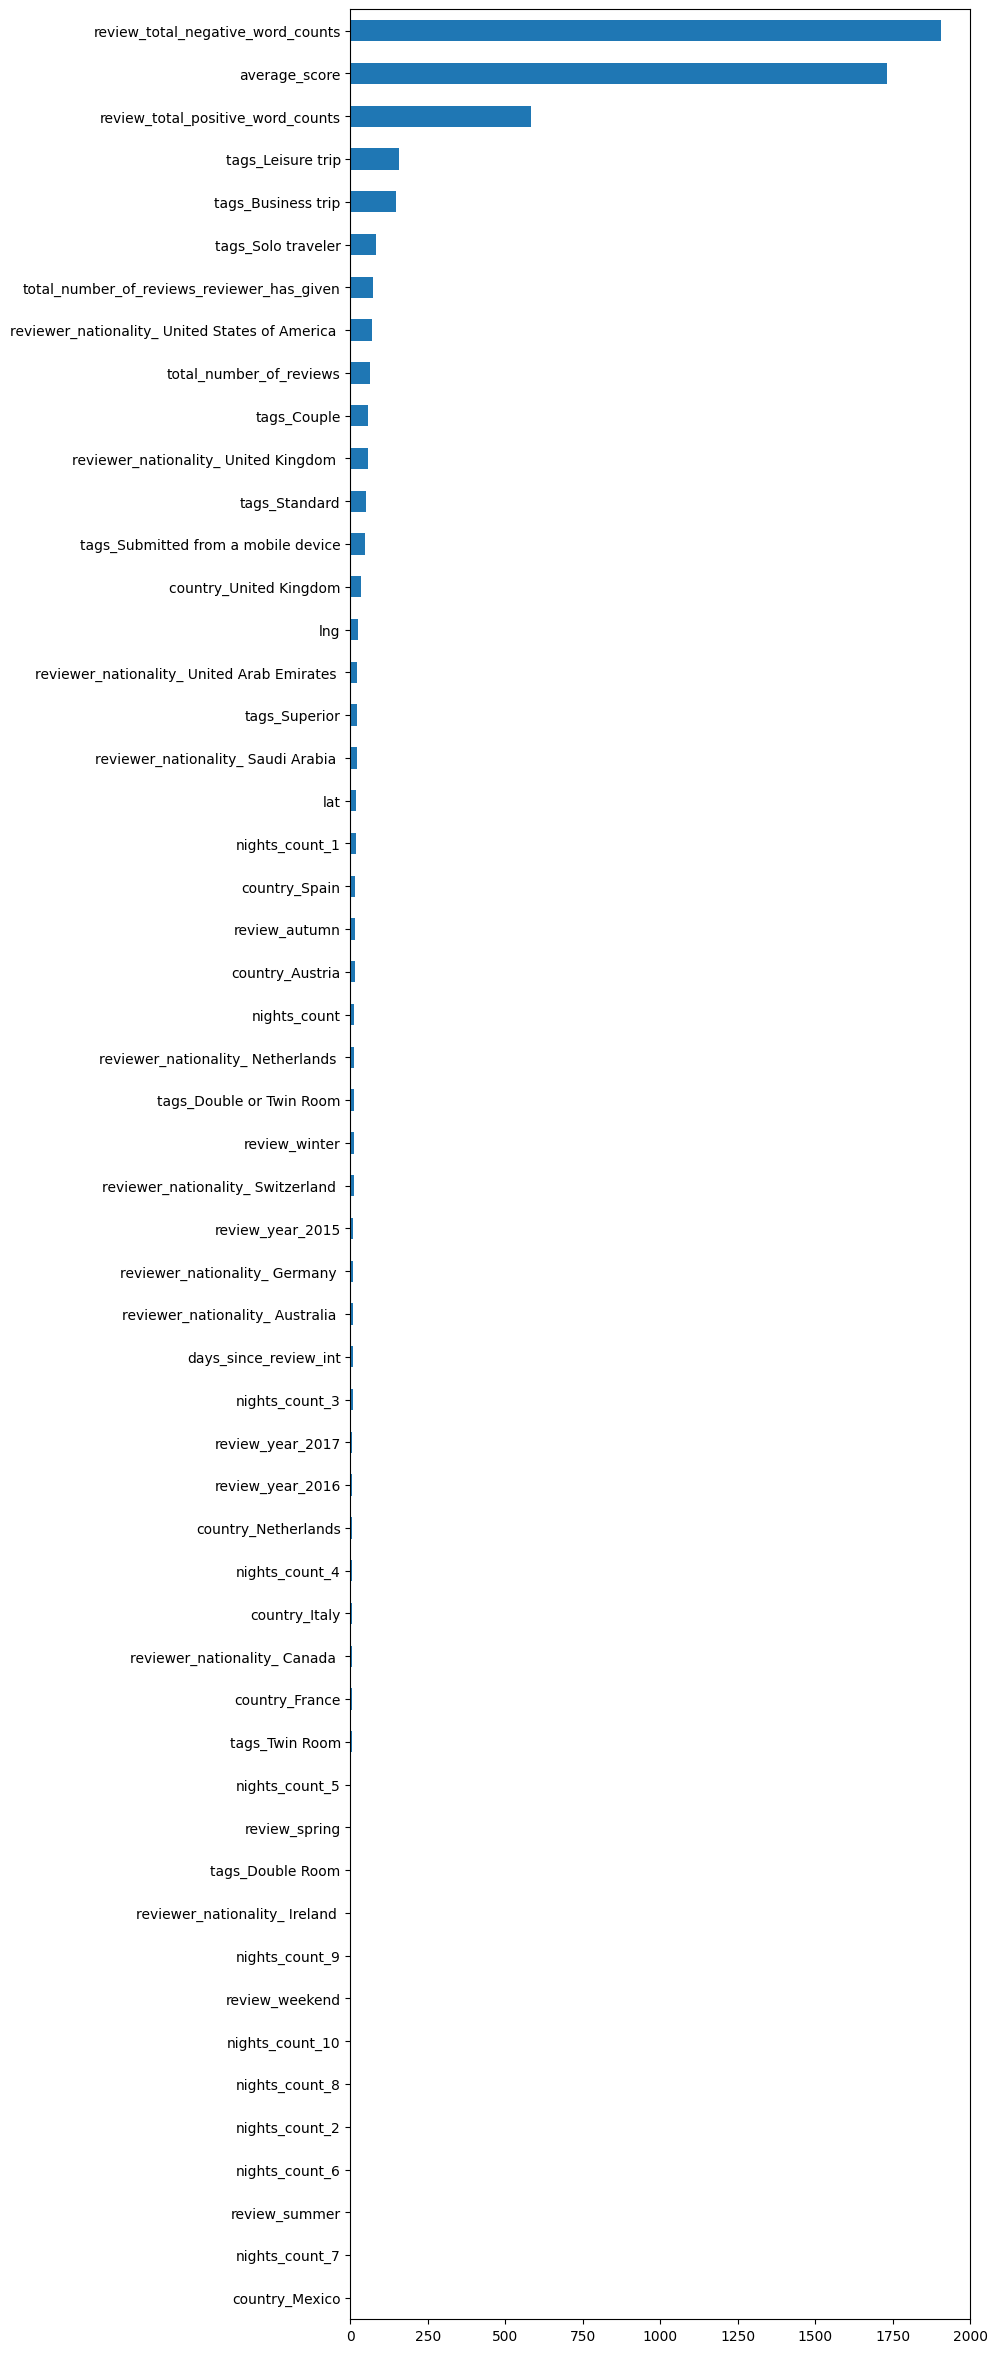

In [509]:
# Строим графие значимости каждого признака с помощью теста anova
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X, y)[0], index = X.columns.to_list())
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', figsize=(8,30))

In [510]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [511]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [513]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [521]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 1), '%')

MAPE: 13.5 %


In [588]:
'''# Создаем список из признаков не входящих в 15 признаков с наибольшим уровнем значимости по тесту Anova
del_columns = imp_num.iloc[:len(imp_num.index.to_list())-15].index.to_list()

# Создаем датафрейм из топ 15 признаков по уровню значимости теста Anova
new_hotels = hotels.drop(del_columns, axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X_new = new_hotels.drop(['reviewer_score'], axis = 1)  
y_new = new_hotels['reviewer_score']

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.25, random_state=42)
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train_new, y_train_new)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred_new 
y_pred_new = regr.predict(X_test_new) 

print('MAPE:', round(metrics.mean_absolute_percentage_error(y_test_new, y_pred_new)*100, 1), '%')

#MAPE: 13.7 %'''

MAPE: 13.7 %
